In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib as mpl
import scienceplots
from scipy.stats import bernoulli
from scipy.optimize import minimize
from betting import *
plt.style.use(['science','no-latex'])
%load_ext autoreload
%autoreload 2

In [2]:
#mpl.rcParams['lines.markersize'] = 10
#mpl.rcParams['lines.linewidth'] = 3
#mpl.rcParams['text.usetex'] = False
#plot_wealth(gap_3, label='$\\Delta=0.7$', c='tab:olive')
#plot_wealth(gap_4, label='$\Delta=0.8$', c='tab:olive')
#plot_wealth(gap_2, label='$\\Delta=0.5$', c='navy')

# Simulated Data - Figure 1

In [8]:
def plot_wealth_std(arr, label, c): 
    """Simple helper to plot given array with std"""
    
    mean = np.mean(arr, axis=0)   
    std = np.std(arr, axis=0)
    plt.plot(range(size), mean, label=label, c=c)
    plt.fill_between(range(len(mean)), mean+std, mean-std, alpha=0.2, color=c)
    
def plot_wealth(arr, label, c): 
    """Plot given array with standard error"""
    
    mean = np.mean(arr, axis=0)
    n = len(arr)
    se = np.std(arr, axis=0, ddof=1) / np.sqrt(n)  # standard error
    plt.plot(range(size), mean, linewidth=2, label=label, c=c)
    plt.fill_between(range(len(mean)), mean-se, mean+se, alpha=0.2, color=c)

In [4]:
def bernoulli_kl(p, q):
    """KL Divergence between two Bernoulli parameters p and q."""
    # Clip q to avoid log(0)
    q = np.clip(q, 1e-10, 1 - 1e-10)
    p = np.clip(p, 1e-10, 1 - 1e-10)
    return p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))

def get_worst_case_parameters(n0, mu0_hat, n1, mu1_hat, tau):
    """
    Finds mu0_star, mu1_star that minimize weighted KL from hats,
    subject to |mu1_star - mu0_star| >= tau.
    """
    # If the empirical data already satisfies the "unfair" condition (Null Hypothesis),
    # the worst case is just the data itself.
    current_gap = abs(mu1_hat - mu0_hat)
    if current_gap >= tau:
        return mu0_hat, mu1_hat

    # Otherwise, we project onto the boundary |mu1 - mu0| = tau.
    # We try both directions: mu1 - mu0 = tau  AND  mu0 - mu1 = tau
    # and pick the one with lower KL cost.

    def objective(x):
        # x[0] = mu0, x[1] = mu1
        return n0 * bernoulli_kl(mu0_hat, x[0]) + n1 * bernoulli_kl(mu1_hat, x[1])

    bnds = ((0.001, 0.999), (0.001, 0.999))
    
    # Direction A: mu1 = mu0 + tau
    cons_A = {'type': 'eq', 'fun': lambda x: x[1] - x[0] - tau}
    res_A = minimize(objective, [mu0_hat, mu1_hat], bounds=bnds, constraints=cons_A)
    
    # Direction B: mu0 = mu1 + tau
    cons_B = {'type': 'eq', 'fun': lambda x: x[0] - x[1] - tau}
    res_B = minimize(objective, [mu0_hat, mu1_hat], bounds=bnds, constraints=cons_B)

    # Return the one with minimal KL (if successful)
    if res_A.success and res_B.success:
        return res_A.x if res_A.fun < res_B.fun else res_B.x
    elif res_A.success:
        return res_A.x
    elif res_B.success:
        return res_B.x
    else:
        # Fallback if optimization fails (rare): return hats
        return mu0_hat, mu1_hat

def test_by_kl_projection(X_group0, X_group1, tau, R=250):
    """
    Simulates the wealth process using the Explicit GLR (Projection).
    assumes data arrives in pairs (or balanced stream) for simplicity.
    """
    n = len(X_group0)
    wealth = np.zeros(n)
    current_wealth = 1.0
    
    # Counts (start with beta priors 1/1 to avoid div by zero initially)
    s0, c0 = 1.0, 2.0  # Sum, Count for Group 0
    s1, c1 = 1.0, 2.0  # Sum, Count for Group 1
    
    for t in range(n):
        # 1. Current Empirical Estimates (Agent's "Truth")
        mu0_hat = s0 / c0
        mu1_hat = s1 / c1
        
        # 2. Regulator's Worst Case (Projection onto Null)
        # "If I assume the world is Unfair (gap>=tau), what fits best?"
        mu0_star, mu1_star = get_worst_case_parameters(c0, mu0_hat, c1, mu1_hat, tau)
        
        # 3. Observe New Data (One from each group for this simulation step)
        x0 = X_group0[t]
        x1 = X_group1[t]
        
        # 4. Compute Likelihood Ratios (Payoff)
        # Prob of x0 under Agent vs Regulator
        p_agent_0 = mu0_hat if x0 == 1 else (1 - mu0_hat)
        p_reg_0   = mu0_star if x0 == 1 else (1 - mu0_star)
        
        p_agent_1 = mu1_hat if x1 == 1 else (1 - mu1_hat)
        p_reg_1   = mu1_star if x1 == 1 else (1 - mu1_star)
        
        # Combined wealth update for this step
        payoff = (p_agent_0 / p_reg_0) * (p_agent_1 / p_reg_1)
        current_wealth *= payoff
        wealth[t] = min(current_wealth,R)
        
        # 5. Update History
        s0 += x0; c0 += 1
        s1 += x1; c1 += 1
        
    return wealth
def test_by_betting_stub(X1, X2, epsilon):
    # This is just a stub to make the code runnable if you copy-paste
    # Replace this call with your actual 'test_by_betting' function
    return test_by_kl_projection(X1, X2, epsilon), None

In [5]:
size = 400
iters = 30 
fairnes_tolerance = 0.6 

gap_1 = []
gap_2 = []
gap_3 = []
for _ in range(iters): 
    
    
    X1 = bernoulli.rvs(0.1, size=size)
    X2 = bernoulli.rvs(0.5, size=size)
    X3 = bernoulli.rvs(0.7, size=size)
    
    wealth, _ = test_by_betting(X1, X2, epsilon=fairnes_tolerance)
    gap_1.append(extend_arr(wealth, size))

    wealth, _ = test_by_betting(X1, X3, epsilon=fairnes_tolerance)
    gap_2.append(extend_arr(wealth, size))

    wealth, _ = test_by_betting_stub(X1, X2,epsilon=fairnes_tolerance)
    gap_3.append(extend_arr(wealth, size))

/usr/local/lib/python3.12/dist-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


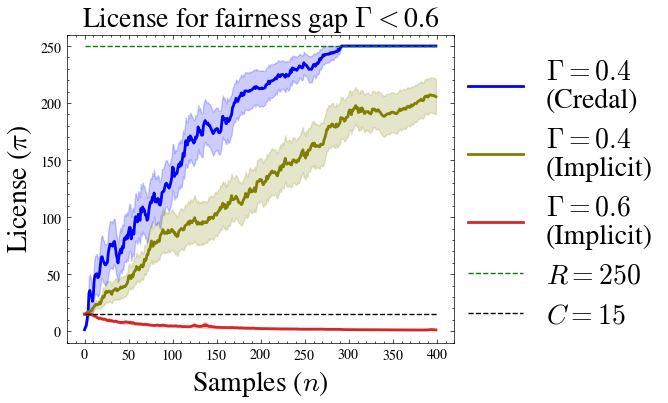

In [11]:
plt.figure(figsize=(5, 4))
plot_wealth(gap_3, label='$\\Gamma=0.4$ \n(Credal)', c='blue')    
plot_wealth(gap_1, label='$\\Gamma=0.4$ \n(Implicit)', c='olive')    
plot_wealth(gap_2, label='$\\Gamma=0.6$ \n(Implicit)', c='#D62728')


plt.hlines(250, 0, size, ls='--', color='g', label='$R=250$')
plt.hlines(15, 0, size, ls='--', color='k', label='$C=15$')
plt.title('License for fairness gap $\\Gamma <$'+ str(fairnes_tolerance), fontsize=20)
plt.ylim(-10, 260)
plt.ylabel('License ($\\pi$)', fontsize=20)
plt.xlabel('Samples ($n$)', fontsize=20)
plt.legend(bbox_to_anchor=(0.97,1), ncol=1, fontsize=20)
plt.savefig("bernoulli-simulation.pdf")